In [59]:
!git clone https://github.com/ethantornga/DataAnalyticsCapstone.git

fatal: destination path 'DataAnalyticsCapstone' already exists and is not an empty directory.


In [60]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
import collections as co
import time

from sklearn import datasets, metrics, neighbors, naive_bayes, linear_model, dummy, pipeline, feature_selection as ftr_sel, model_selection as skms, preprocessing as skpre
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import tree, svm, ensemble as ens
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ParameterGrid
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
#1. Load the Data

data = "/content/DataAnalyticsCapstone/mba_decision_new.csv"
df = pd.read_csv(data)

print(df.head())

   Person ID  Age  Gender Undergraduate Major  Undergraduate GPA  \
0          1   27    Male                Arts               3.18   
1          2   24    Male                Arts               3.03   
2          3   33  Female            Business               3.66   
3          4   31    Male         Engineering               2.46   
4          5   28  Female            Business               2.75   

   Years of Work Experience Current Job Title  Annual Salary (Before MBA)  \
0                         8      Entrepreneur                       90624   
1                         4           Analyst                       53576   
2                         9          Engineer                       79796   
3                         1           Manager                      105956   
4                         9      Entrepreneur                       96132   

  Has Management Experience  GRE/GMAT Score  Undergrad University Ranking  \
0                        No             688        

In [62]:
#2. Data Cleaning/Preprocessing

#Missing Values (None)
missing_values = df.isnull().sum()
print(missing_values)

#Detecting Outliers w/ z-score (None)
z_scores = df.select_dtypes(include=['float64', 'int64']).apply(zscore)

outliers = df[(z_scores > 3).any(axis=1)]
print("\nOutliers using Z-Score:\n", outliers)

#Encoding (Dummy Variables)
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
df['Undergraduate Major'] = df['Undergraduate Major'].map({'Business': 1, 'Economics': 1, 'Arts': 0,  'Science': 0, 'Engineering': 0})
df['Current Job Title'] = df['Current Job Title'].map({'Manager': 1, 'Entrepreneur': 0, 'Analyst': 0, 'Engineer': 0, 'Consultant': 0, })
df['Has Management Experience'] = df['Has Management Experience'].map({'No': 0, 'Yes': 1})
df['MBA Funding Source'] = df['MBA Funding Source'].map({'Scholarship': 1, 'Employer': 1, 'Loan': 0, 'Self-funded': 0})
df['Desired Post-MBA Role'] = df['Desired Post-MBA Role'].map({'Finance Manager': 1, 'Startup Founder': 1, 'Executive': 1, 'Marketing Director': 1, 'Consultant': 0})
df['Online vs. On-Campus MBA'] = df['Online vs. On-Campus MBA'].map({'Online': 0, 'On-Campus': 1})
df['Location Preference (Post-MBA)'] = df['Location Preference (Post-MBA)'].map({'Domestic': 0, 'International': 1})
df['Reason for MBA'] = df['Reason for MBA'].map({'Career Growth': 1, 'Entrepreneurship': 1, 'Networking': 0, 'Skill Enhancement': 0})
df['Decided to Pursue MBA?'] = df['Decided to Pursue MBA?'].map({'No': 0, 'Yes': 1})

print(df.head())


Person ID                         0
Age                               0
Gender                            0
Undergraduate Major               0
Undergraduate GPA                 0
Years of Work Experience          0
Current Job Title                 0
Annual Salary (Before MBA)        0
Has Management Experience         0
GRE/GMAT Score                    0
Undergrad University Ranking      0
MBA Funding Source                0
Desired Post-MBA Role             0
Expected Post-MBA Salary          0
Location Preference (Post-MBA)    0
Reason for MBA                    0
Online vs. On-Campus MBA          0
Decided to Pursue MBA?            0
Salary Difference                 0
Percent of Life Worked            0
dtype: int64

Outliers using Z-Score:
 Empty DataFrame
Columns: [Person ID, Age, Gender, Undergraduate Major, Undergraduate GPA, Years of Work Experience, Current Job Title, Annual Salary (Before MBA), Has Management Experience, GRE/GMAT Score, Undergrad University Ranking, MBA F

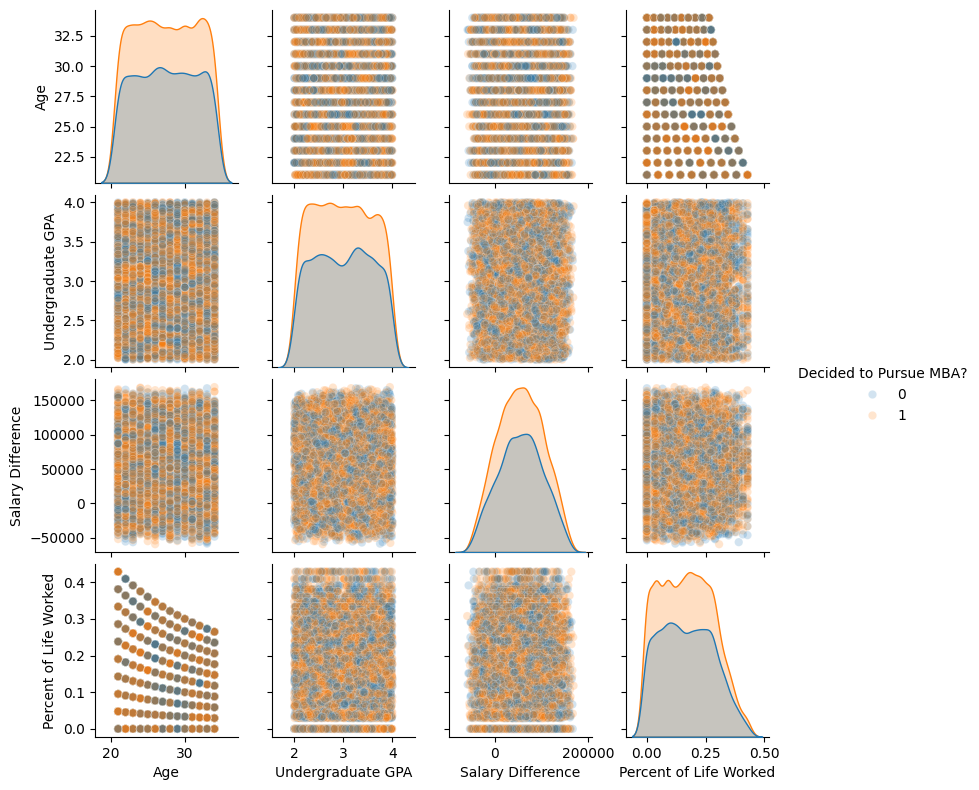

In [63]:
sns.pairplot(df[['Age', 'Undergraduate GPA', 'Salary Difference', 'Percent of Life Worked', 'Decided to Pursue MBA?']],
             height=2, hue='Decided to Pursue MBA?', plot_kws={'alpha':.2});

In [36]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Person ID                       10000 non-null  int64  
 1   Age                             10000 non-null  int64  
 2   Gender                          10000 non-null  int64  
 3   Undergraduate Major             10000 non-null  int64  
 4   Undergraduate GPA               10000 non-null  float64
 5   Years of Work Experience        10000 non-null  int64  
 6   Current Job Title               10000 non-null  int64  
 7   Annual Salary (Before MBA)      10000 non-null  int64  
 8   Has Management Experience       10000 non-null  int64  
 9   GRE/GMAT Score                  10000 non-null  int64  
 10  Undergrad University Ranking    10000 non-null  int64  
 11  MBA Funding Source              10000 non-null  int64  
 12  Desired Post-MBA Role           1

<ipython-input-65-3a65b70f1803>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Decided to Pursue MBA?', palette='viridis')


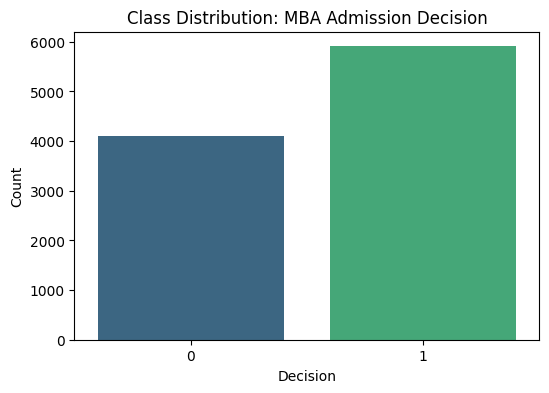

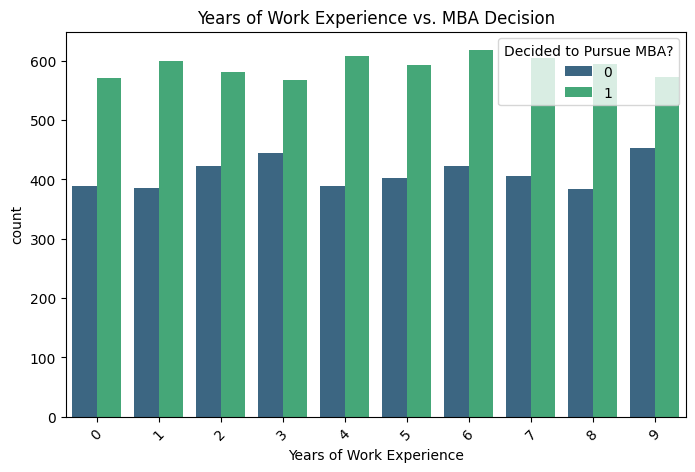

In [65]:
# Decision Target Class Chart
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Decided to Pursue MBA?', palette='viridis')
plt.title('Class Distribution: MBA Admission Decision')
plt.xlabel('Decision')
plt.ylabel('Count')
plt.show()


#Categorical Feature vs. Target
categorical_col = 'Years of Work Experience' if 'Years of Work Experience' in df.columns else df.select_dtypes(include='object').columns[1]

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=categorical_col, hue='Decided to Pursue MBA?', palette='viridis')
plt.title(f'{categorical_col} vs. MBA Decision')
plt.xticks(rotation=45)
plt.show()



In [38]:
#Creating training and testing splits in the data
(data_train_ftrs, data_test_ftrs,
data_train_tgt, data_test_tgt) = skms.train_test_split(df.drop('Decided to Pursue MBA?', axis=1),
                                                      df['Decided to Pursue MBA?'],
                                                      test_size=.30,
                                                      random_state=42)
#Shape of train/test features
print("Train features shape:", data_train_ftrs.shape)
print("Test features shape:", data_test_ftrs.shape)

Train features shape: (7000, 19)
Test features shape: (3000, 19)


In [39]:
# DataFrame Correlation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                                Person ID       Age    Gender  \
Person ID                        1.000000  0.006182 -0.000478   
Age                              0.006182  1.000000 -0.001644   
Gender                          -0.000478 -0.001644  1.000000   
Undergraduate Major              0.003263  0.007988  0.012496   
Undergraduate GPA                0.004599  0.014800  0.005598   
Years of Work Experience         0.002018 -0.000798 -0.005432   
Current Job Title                0.002389  0.002010  0.012994   
Annual Salary (Before MBA)       0.001637  0.011386 -0.012550   
Has Management Experience       -0.000675  0.005230 -0.006506   
GRE/GMAT Score                   0.021121  0.002036  0.003192   
Undergrad University Ranking     0.006243 -0.003281 -0.015647   
MBA Funding Source               0.008507 -0.005496 -0.008636   
Desired Post-MBA Role            0.007743 -0.001699  0.002167   
Expected Post-MBA Salary         0.002500  0.016200 -0.003292   
Location Preference (Post

In [40]:
#4. Modeling

#Linear Regression Modeling
lr = linear_model.LinearRegression()
fit = lr.fit(data_train_ftrs, data_train_tgt)
preds = lr.predict(data_train_ftrs)

mse = mean_squared_error(data_train_tgt, preds)

#Mean Squared Error for evaluation of model
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

MSE:  0.24193221142858715
RMSE:  0.49186605029071395


In [41]:
#5. Model Evaluation

#Creation of Linear Regression and KNN models
lrknn = [linear_model.LinearRegression(),
              neighbors.KNeighborsRegressor(n_neighbors=3),
              neighbors.KNeighborsRegressor(n_neighbors=10)]

#Creation of Lasso and Ridge models
penalized_lr = [linear_model.Lasso(),
                linear_model.Ridge()]

#Creation of SVR models
svrs = [svm.SVR(), svm.NuSVR()]

#Decision Tree Regressor models
dtrees = [tree.DecisionTreeRegressor(max_depth=md) for md in [1, 3, 5, 10]]

#Comibining all models
reg_models = lrknn + penalized_lr + svrs + dtrees

#RMS_Error function
def rms_error(actual, predicted):
  ' root-mean-squared-error function ' #lesser values are better (a<b means a is better)
  mse = metrics.mean_squared_error(actual, predicted)
  return np.sqrt(mse)
rms_scorer = metrics.make_scorer(rms_error)

scaler = StandardScaler()

def rms_error(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

errors = {}
for model in reg_models:
    pipe = pipeline.make_pipeline(scaler, model)
    preds = skms.cross_val_predict(pipe,
                                   data_train_ftrs, data_train_tgt,
                                   cv=10)
    key = (model.__class__.__name__ +
           str(model.get_params().get('max_depth', "")) +
           str(model.get_params().get('n_neighbors', "")))
    errors[key] = rms_error(data_train_tgt, preds)

#Displaying RMSE
df = pd.DataFrame.from_dict(errors, orient='index').sort_values(0)
df.columns=['RMSE']
display(df)

,RMSE
Lasso,0.492336
Ridge,0.493100
LinearRegression,0.493101
DecisionTreeRegressor1,0.493243
DecisionTreeRegressor3,0.495380
NuSVR,0.499193
DecisionTreeRegressor5,0.500306
KNeighborsRegressor10,0.514723
DecisionTreeRegressor10,0.534216
SVR,0.547929


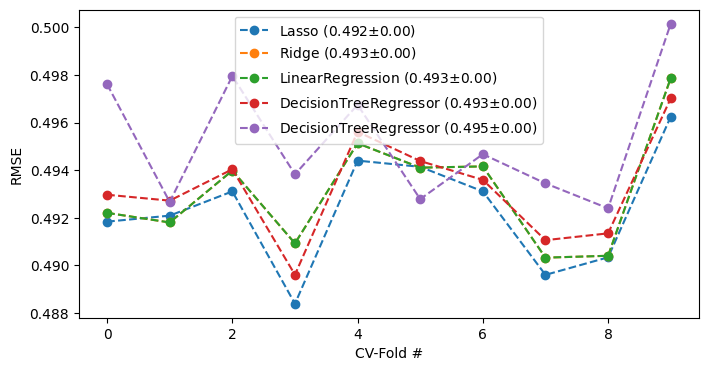

In [42]:
def rms_error(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

rms_scorer = make_scorer(rms_error)

#Top performing models for further evaluation
better_models = [linear_model.Lasso(),
                 linear_model.Ridge(),
                 linear_model.LinearRegression(),
                 tree.DecisionTreeRegressor(max_depth=1),
                 tree.DecisionTreeRegressor(max_depth=3)]

#Line plot of RMSE and CV-Fold
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for model in better_models:
    pipe = pipeline.make_pipeline(scaler, model)
    cv_results = skms.cross_val_score(pipe,
                                      data_train_ftrs, data_train_tgt,
                                      scoring = rms_scorer,
                                      cv=10)

    my_lbl = "{:s} ({:5.3f}$\pm${:.2f})".format(model.__class__.__name__,
                                                cv_results.mean(),
                                                cv_results.std())
    ax.plot(cv_results, 'o--', label=my_lbl)
    ax.set_xlabel('CV-Fold #')
    ax.set_ylabel("RMSE")
    ax.legend()

In [43]:
# Classification model to predict 'Decide to Pursue MBA?'

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(data_train_ftrs, data_train_tgt)

# Make predictions on the test set
rf_predictions = rf_classifier.predict(data_test_ftrs)

# Evaluate the model
print(classification_report(data_test_tgt, rf_predictions))
print("Accuracy:", accuracy_score(data_test_tgt, rf_predictions))

              precision    recall  f1-score   support

           0       0.41      0.16      0.23      1205
           1       0.60      0.84      0.70      1795

    accuracy                           0.57      3000
   macro avg       0.50      0.50      0.46      3000
weighted avg       0.52      0.57      0.51      3000

Accuracy: 0.569


In [44]:
# Drop 'Person ID' from the feature columns and corresponding importances
mask = data_train_ftrs.columns != 'Person ID'
filtered_columns = data_train_ftrs.columns[mask]
filtered_importances = feature_importances[mask]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': filtered_columns,
    'Importance': filtered_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feature_importance_df

,Feature,Importance
9,Undergrad University Ranking,0.098983
12,Expected Post-MBA Salary,0.098890
8,GRE/GMAT Score,0.098879
6,Annual Salary (Before MBA),0.098585
16,Salary Difference,0.097551
3,Undergraduate GPA,0.096548
17,Percent of Life Worked,0.076248
0,Age,0.059472
4,Years of Work Experience,0.039600
1,Gender,0.019715


In [45]:
#KNN Set-Up
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
fit = knn.fit(data_train_ftrs, data_train_tgt)

#3 Nearest Neighbors (3NN) accuracy prediction
predictions = fit.predict(data_test_ftrs)
print("3NN Accuracy:", metrics.accuracy_score(data_test_tgt, predictions))

#KNN Classifier for 3NN
models = {'kNN': neighbors.KNeighborsClassifier(n_neighbors=3)}

# Prediction Accuracy Score
for name, model in models.items():
    fit = model.fit(data_train_ftrs, data_train_tgt)
    predictions = fit.predict(data_test_ftrs)
    score = metrics.accuracy_score(data_test_tgt, predictions)
    print("{:>3s}: {:0.2f}".format(name, score))

#Time to run KNN
start_time = time.time()
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
fit = knn.fit(data_train_ftrs, data_train_tgt)
preds = knn.predict(data_test_ftrs)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Prediction time for k-NN: {elapsed_time:.2f} seconds")

3NN Accuracy: 0.5096666666666667
kNN: 0.51
Prediction time for k-NN: 0.45 seconds


In [46]:
#KNN Accuracy
tgt_preds = (neighbors.KNeighborsClassifier()
                      .fit(data_train_ftrs, data_train_tgt)
                      .predict(data_test_ftrs))

print("accuracy:", metrics.accuracy_score(data_test_tgt,
                                          tgt_preds))

# KNN Confusion Matrix
cm = metrics.confusion_matrix(data_test_tgt,
                              tgt_preds)
print("confusion matrix:", cm, sep="\n")

accuracy: 0.53
confusion matrix:
[[ 401  804]
 [ 606 1189]]


In [66]:
#Classification Model
print(metrics.classification_report(data_test_tgt,
                                    tgt_preds))


              precision    recall  f1-score   support

           0       0.40      0.33      0.36      1205
           1       0.60      0.66      0.63      1795

    accuracy                           0.53      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.52      0.53      0.52      3000



Baseline accuracy:  0.5983333333333334


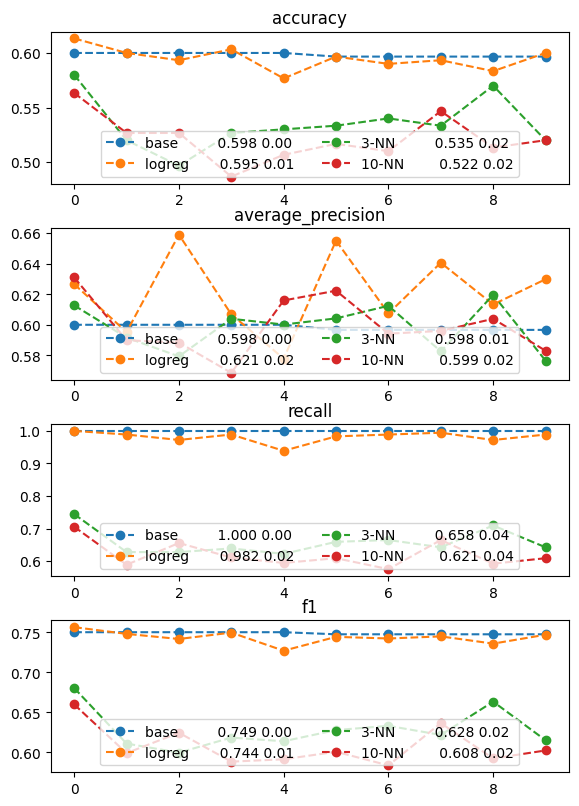

In [48]:
# Visual - Cross-Val Score

#Baseline accuracy to test against
baseline = dummy.DummyClassifier(strategy="most_frequent")
baseline.fit(data_train_ftrs, data_train_tgt)
base_preds = baseline.predict(data_test_ftrs)
base_acc = metrics.accuracy_score(base_preds, data_test_tgt)
print("Baseline accuracy: ", base_acc)

#Creation of necessary classifiers
classifiers = {'base'  : baseline,
               'logreg': linear_model.LogisticRegression(solver='lbfgs', max_iter=10000),
               '3-NN'  : neighbors.KNeighborsClassifier(n_neighbors=3),
               '10-NN' : neighbors.KNeighborsClassifier(n_neighbors=10)}

#Measures plotted
msrs = ['accuracy', 'average_precision', 'recall', 'f1']

#Format the graphs
fig, axes = plt.subplots(len(msrs), 1, figsize=(6, 2*len(msrs)))
fig.tight_layout()

#Cross Validation Score
for mod_name, model in classifiers.items():
    cvs = skms.cross_val_score
    cv_results = {msr:cvs(model, data_test_ftrs, data_test_tgt,
                          scoring=msr, cv=10) for msr in msrs}

#Graph set-up
    for ax, msr in zip(axes, msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name,
                                               msr_results.mean(),
                                               msr_results.std())
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower center', ncol=2)

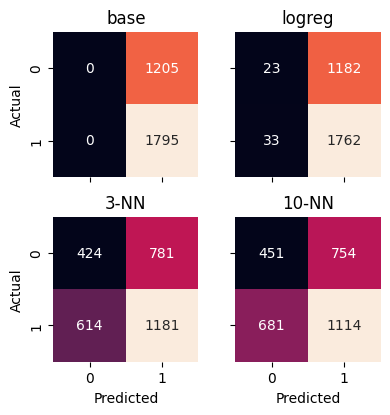

In [49]:
# Visual - Cross-Val Predict Confusion Matrix

#Graph Layout Set-Up
fig, axes = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
fig.tight_layout()

#Cross Validation Prediction
for ax, (mod_name, model) in zip(axes.flat, classifiers.items()):
    preds = skms.cross_val_predict(model,
                                   data_test_ftrs, data_test_tgt,
                                   cv=10)
    # Confusion Matrix
    cm = metrics.confusion_matrix(data_test_tgt, preds)
    sns.heatmap(cm, annot=True, ax=ax,
                cbar=False, square=True, fmt="d")

    ax.set_title(mod_name)

axes[1,0].set_xlabel('Predicted')
axes[1,1].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[1,0].set_ylabel('Actual');

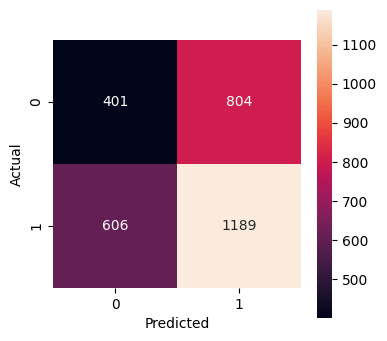

In [50]:
# Actual vs Predicted Confusion Matrix

#Heatmap of Predicted and Actual
fig, ax = plt.subplots(1,1,figsize=(4,4))
cm = metrics.confusion_matrix(data_test_tgt, tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True, fmt="d")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

In [53]:
print("Dataset shape:", df.shape)
print("\nTarget column value counts:\n", data_train_tgt.value_counts())


Dataset shape: (11, 1)

Target column value counts:
 Decided to Pursue MBA?
1    4112
0    2888
Name: count, dtype: int64
